In [ ]:
!pip install torch TorchCRF seqeval transformers --quiet

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?seems not to be NE tag.*?")

In [2]:
from utils import *

/users/eleves-a/2021/ivan.tchomba-ngueko/ensae/concept-ner/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
labels, labels_vocab, labels_vocab_inv = get_labels()

In [4]:
len(labels_vocab.values())

59

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import AutoModel, AutoTokenizer
from TorchCRF import CRF
import numpy as np
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report
from tqdm import tqdm
import os
import pickle


In [57]:
# Configuration
class Config:
    model_name = "microsoft/deberta-v3-base"
    encoder_outdim = 768
    max_length = 80
    batch_size = 256  # Peut être augmenté car moins de mémoire nécessaire
    epochs = 100      # Peut être augmenté car entraînement plus rapide

    learning_rate = 5e-3  # Peut être plus élevé car moins de paramètres
    hidden_dim = 256
    dropout = 0.1
    num_labels = len(labels)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    embeddings_dir = "precalculated_embeddings"

    kernel_size = 3
    padding = 1

    ignore_index=-100
config = Config()


In [7]:
from datasets import Dataset

In [8]:

# Étape 2: Créer le dataset qui utilise les embeddings précalculés
class EmbeddingsDataset(Dataset):
    def __init__(self, data_path, parts=None, complement='_5000'):
        # Charger les données précalculées
        # parts = 5
        data = [None] * parts
        for i in range(parts):
            index = f'_{i+1}' if parts > 1 else ''
            with open(data_path + index + f'{complement}_data.pkl', 'rb') as f:
                data[i] = pickle.load(f)
        
        self.embeddings = torch.cat([data[i]['embeddings'] for i in range(parts)], dim=0)
        self.attention_masks = torch.cat([data[i]['attention_masks'] for i in range(parts)], dim=0).to(torch.uint8)
        self.labels = torch.cat([data[i]['labels'] for i in range(parts)], dim=0).to(torch.long)
        # self.labels[self.labels == -100] = config.num_labels  # Remplacer -100 par num_labels
        self.tag2id = data[0]['tag2id']
        self.id2tag = data[0]['id2tag']

        # redo the labels
        for label, id in self.tag2id.items():
            if id == -100:
                continue
            self.labels[self.labels == id] = labels_vocab[label]
        self.tag2id = labels_vocab
        self.id2tag = labels_vocab_inv
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


In [49]:
class BiLSTM_CNN_Classifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lstm = nn.LSTM(config.encoder_outdim, config.hidden_dim, bidirectional=True, batch_first=True)
        self.conv = nn.Conv1d(config.hidden_dim * 2, config.hidden_dim, config.kernel_size, padding=config.padding)
        self.norm = nn.LayerNorm(config.hidden_dim)
        self.dropout = nn.Dropout(config.dropout)
        self.classifier = nn.Linear(config.hidden_dim, config.num_labels)

    def forward(self, embedding, attention_mask, labels=None):
        lstm_out, _ = self.lstm(embedding)
        conv_in = lstm_out.transpose(1, 2)  # [B, D, T]
        conv_out = self.conv(conv_in).transpose(1, 2)
        normed = self.norm(conv_out)
        dropped = self.dropout(normed)
        logits = self.classifier(dropped)
        if labels is not None:
            loss = nn.CrossEntropyLoss(ignore_index=config.ignore_index)(logits.view(-1, logits.size(-1)), labels.view(-1))
            return loss
        return torch.argmax(logits, dim=-1)


In [12]:
train_data = EmbeddingsDataset('data/train', 4)
test_data = EmbeddingsDataset('data/test', 1, '')
val_data = EmbeddingsDataset('data/valid', 1, '')

In [13]:
# Obtenir les mappings tag<->id et mettre à jour config
tag2id = train_data.tag2id
id2tag = train_data.id2tag
# config.num_labels = len(tag2id)

# Créer les dataloaders
train_dataloader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=config.batch_size)

# Obtenir la dimension des embeddings
embedding_dim = train_data.embeddings.size(-1)


In [52]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

def evaluate(model, dataloader, id2tag, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            embeddings = batch['embeddings'].to(device)          # (B, T, D)
            attention_mask = batch['attention_mask'].to(device)  # (B, T)
            labels = batch['labels'].to(device)                  # (B, T)

            # logits = model(embeddings, attention_mask)           # (B, T, num_labels)
            # predictions = torch.argmax(logits, dim=-1)           # (B, T)
            # print(predictions.shape)
            predictions = model(embeddings, attention_mask)        # (B, T)

            # Convert predictions and labels to lists of tag names
            for i in range(labels.size(0)):  # for each sequence
                pred_seq = []
                label_seq = []
                for j in range(labels.size(1)):
                    if attention_mask[i, j] == 1 and labels[i, j] != -100:
                        pred_tag = id2tag[predictions[i, j].item()]
                        label_tag = id2tag[labels[i, j].item()]
                        pred_seq.append(pred_tag)
                        label_seq.append(label_tag)
                all_preds.append(pred_seq)
                all_labels.append(label_seq)

    return {
        'f1': f1_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'report': classification_report(all_labels, all_preds, zero_division=0)
    }


In [15]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [53]:

model = BiLSTM_CNN_Classifier(config).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)


In [73]:
model

BiLSTM_CNN_Classifier(
  (lstm): LSTM(768, 256, batch_first=True, bidirectional=True)
  (conv): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=256, out_features=59, bias=True)
)

In [54]:
evaluate(model, val_dataloader, id2tag, config.device)

{'f1': np.float64(0.014797277300976621),
 'precision': np.float64(0.01012282359292752),
 'recall': np.float64(0.02749266862170088),
 'report': '              precision    recall  f1-score   support\n\n      ANIMAL       0.00      0.00      0.00        56\n    ARTIFACT       0.00      0.00      0.00        94\n       ASSET       0.00      0.00      0.00         0\n     BIOLOGY       0.00      0.04      0.00        24\n   CELESTIAL       0.00      0.00      0.00         0\n     CULTURE       0.00      0.00      0.00         0\n    DATETIME       0.00      0.00      0.00         0\n  DISCIPLINE       0.00      0.00      0.00        36\n     DISEASE       0.00      0.00      0.00        58\n       EVENT       0.02      0.03      0.02      1430\n     FEELING       0.00      0.00      0.00         0\n        FOOD       0.00      0.00      0.00        31\n       GROUP       0.00      0.00      0.00       205\n    LANGUAGE       0.01      0.05      0.01       423\n         LAW       0.00      

In [58]:
# from tqdm import trange
num_epochs = 100
history = [None] * num_epochs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        embeddings = batch['embeddings'].to(device)           # (B, T, D)
        attention_mask = batch['attention_mask'].to(device)   # (B, T)
        labels = batch['labels'].to(device)                   # (B, T)

        optimizer.zero_grad()
        loss = model(embeddings, attention_mask, labels)            # (B, T, num_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        total_loss += loss.item()
        
    total_loss /= len(train_dataloader.dataset)
    
    # Validation
    history[epoch] = {
        'epoch': epoch,
        'train_loss': total_loss,
        'metrics': evaluate(model, val_dataloader, id2tag, device)
    }
    

    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1:<4} - Loss: {total_loss:<7.5f} - F1: {history[epoch]['metrics']['f1']:<6.4f} - Precision: {history[epoch]['metrics']['precision']:<6.4f} - Recall: {history[epoch]['metrics']['recall']:<6.4f}")


Epoch 1    - Loss: 0.02023 - F1: 0.0066 - Precision: 0.0079 - Recall: 0.0057
Epoch 11   - Loss: 0.01019 - F1: 0.1979 - Precision: 0.1586 - Recall: 0.2630
Epoch 21   - Loss: 0.00892 - F1: 0.2196 - Precision: 0.1705 - Recall: 0.3087
Epoch 31   - Loss: 0.00831 - F1: 0.2483 - Precision: 0.2023 - Recall: 0.3212
Epoch 41   - Loss: 0.00788 - F1: 0.2371 - Precision: 0.1862 - Recall: 0.3265
Epoch 51   - Loss: 0.00751 - F1: 0.2601 - Precision: 0.2094 - Recall: 0.3431
Epoch 61   - Loss: 0.00718 - F1: 0.2448 - Precision: 0.1942 - Recall: 0.3313
Epoch 71   - Loss: 0.00682 - F1: 0.2522 - Precision: 0.2048 - Recall: 0.3281
Epoch 81   - Loss: 0.00642 - F1: 0.2531 - Precision: 0.2047 - Recall: 0.3315
Epoch 91   - Loss: 0.00598 - F1: 0.2576 - Precision: 0.2124 - Recall: 0.3273


In [61]:
# from tqdm import trange
num_epochs = 200
history += [None] * num_epochs

for epoch in range(100, 100 + num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        embeddings = batch['embeddings'].to(device)           # (B, T, D)
        attention_mask = batch['attention_mask'].to(device)   # (B, T)
        labels = batch['labels'].to(device)                   # (B, T)

        optimizer.zero_grad()
        loss = model(embeddings, attention_mask, labels)            # (B, T, num_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        total_loss += loss.item()
        
    total_loss /= len(train_dataloader.dataset)
    
    # Validation
    history[epoch] = {
        'epoch': epoch,
        'train_loss': total_loss,
        'metrics': evaluate(model, val_dataloader, id2tag, device)
    }
    

    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1:<4} - Loss: {total_loss:<7.5f} - F1: {history[epoch]['metrics']['f1']:<6.4f} - Precision: {history[epoch]['metrics']['precision']:<6.4f} - Recall: {history[epoch]['metrics']['recall']:<6.4f}")


Epoch 101  - Loss: 0.00551 - F1: 0.2674 - Precision: 0.2228 - Recall: 0.3343
Epoch 111  - Loss: 0.00506 - F1: 0.2296 - Precision: 0.1817 - Recall: 0.3117
Epoch 121  - Loss: 0.00467 - F1: 0.2516 - Precision: 0.2042 - Recall: 0.3275
Epoch 131  - Loss: 0.00435 - F1: 0.2396 - Precision: 0.1909 - Recall: 0.3218
Epoch 141  - Loss: 0.00407 - F1: 0.2582 - Precision: 0.2138 - Recall: 0.3259
Epoch 151  - Loss: 0.00380 - F1: 0.2485 - Precision: 0.2021 - Recall: 0.3226
Epoch 161  - Loss: 0.00362 - F1: 0.2424 - Precision: 0.1951 - Recall: 0.3200
Epoch 171  - Loss: 0.00344 - F1: 0.2541 - Precision: 0.2090 - Recall: 0.3239
Epoch 181  - Loss: 0.00331 - F1: 0.2484 - Precision: 0.2017 - Recall: 0.3233
Epoch 191  - Loss: 0.00313 - F1: 0.2422 - Precision: 0.1947 - Recall: 0.3203
Epoch 201  - Loss: 0.00298 - F1: 0.2486 - Precision: 0.2028 - Recall: 0.3212
Epoch 211  - Loss: 0.00283 - F1: 0.2412 - Precision: 0.1937 - Recall: 0.3195
Epoch 221  - Loss: 0.00271 - F1: 0.2361 - Precision: 0.1894 - Recall: 0.3133

In [63]:
metrics = evaluate(model, val_dataloader, id2tag=train_data.id2tag, device=device)

In [64]:
print(metrics['report'])

              precision    recall  f1-score   support

      ANIMAL       0.44      0.12      0.19        56
    ARTIFACT       0.36      0.32      0.34        94
       ASSET       0.00      0.00      0.00         0
     BIOLOGY       0.20      0.17      0.18        24
  DISCIPLINE       0.07      0.08      0.08        36
     DISEASE       0.35      0.28      0.31        58
       EVENT       0.50      0.58      0.54      1430
        FOOD       0.15      0.13      0.14        31
       GROUP       0.06      0.01      0.02       205
    LANGUAGE       0.24      0.35      0.29       423
         LAW       0.00      0.00      0.00       185
         LOC       0.23      0.20      0.21       222
     MEASURE       0.14      0.14      0.14       160
       MEDIA       0.35      0.39      0.37      1368
       MONEY       0.00      0.00      0.00       216
         ORG       0.16      0.25      0.19       489
        PART       0.02      0.04      0.02        50
         PER       0.46    

In [69]:
losses = [history[i]['train_loss'] for i in range(num_epochs+100) if history[i] is not None]

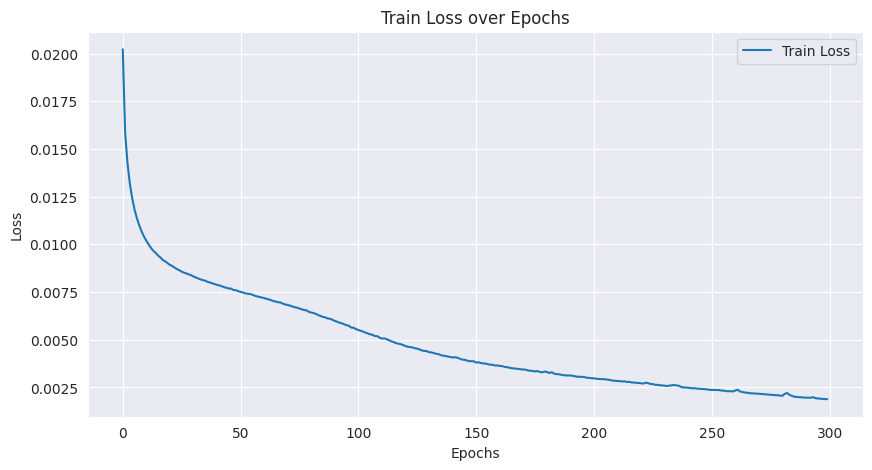

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Train Loss')
plt.title('Train Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
f1_score = [history[i]['metrics']['f1'] for i in range(num_epochs+100) if history[i] is not None]

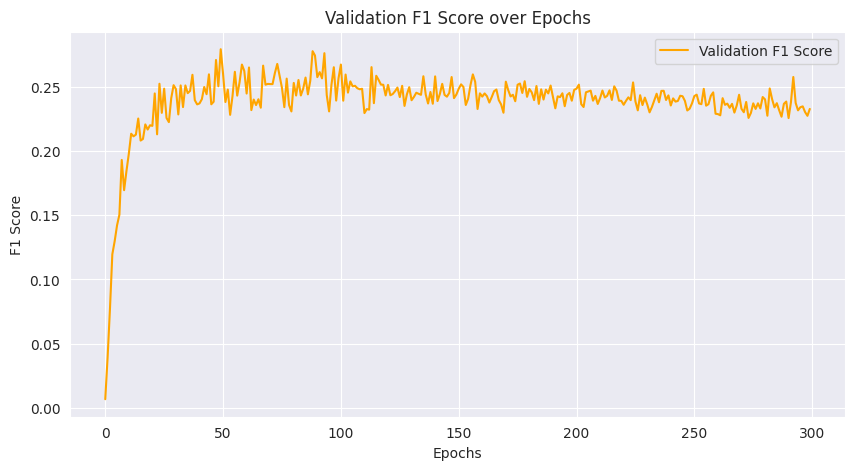

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(f1_score, label='Validation F1 Score', color='orange')
plt.title('Validation F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [74]:
model

BiLSTM_CNN_Classifier(
  (lstm): LSTM(768, 256, batch_first=True, bidirectional=True)
  (conv): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=256, out_features=59, bias=True)
)